# Protein-like MSM building

Dependencies can be installed in a new conda environment with
`conda env create -f environment.yml`
or installed into an existing environment with
`conda env update --name <existing environment name> --file environment.yml`

# Load dependencies

In [1]:
import MDAnalysis as mda
import MDAnalysis.analysis.rms
import MDAnalysis.analysis.align
import numpy as np
import tqdm.auto as tqdm
from deeptime.clustering import KMeans
from matplotlib import pyplot as plt

/Users/russojd/opt/anaconda3/envs/protein-like_msm/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/Users/russojd/opt/anaconda3/envs/protein-like_msm/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


## Load DE Shaw trajectories

I'll be using the Trp-cage (2JOF) folding trajectory #2. This is 105 DCD files + a topology .mae, indexed as 0-104.

In [2]:
trajectory_base_path = '/Users/russojd/Research/desres_trajectories/DESRES-Trajectory_2JOF-0-protein 2/2JOF-0-protein'
n_traj_files = 105

traj_name = "2JOF-0-protein-{traj_idx:0>3d}.dcd"

# MDAnalysis can't read the .mae
# topology_name = "2JOF-0-protein.mae"

# So instead, use this PDB I got from converting the .mae
topology_name = "2JOF.pdb"

model_name = '2JOF'

topology_path = f"{trajectory_base_path}/{topology_name}"
traj_paths = [f"{trajectory_base_path}/{traj_name.format(traj_idx=_idx)}" for _idx in range(n_traj_files)]

In [3]:
# Explicitly set the timestep here, since letting MDAnalysis infer it gives a wonky result.

# Each of my trajectory DCD files start 2e6 units apart
# The very first trajectory starts at 200 units
# The whole trajectory is 208µs, and all the trajectories are 1e6 units, so a unit is 200ps.

dt = 200

In [4]:
universe = mda.Universe(topology_path, traj_paths, dt=dt )

In [5]:
total_time_ps = len(universe.trajectory) * universe.trajectory.dt

print(f"Total trajectory time is {total_time_ps/1e6} µs")

Total trajectory time is 208.8 µs


## Prepare trajectory (align+center)

This aligns alpha-carbons on the provided reference topology, and spits out the result in `aligned_2JOF.dcd`. This only needs to be run once, to make that file.

# Model-building

In [50]:
# Stride the trajectory
stride = 1

# Number of clusters for k-means
n_clusters = 1000

## Featurize trajectory

In the original Shaw publication, they featurized the folding transition with alpha-carbon RMSD.

[MDAnalysis RMSD documentation](https://www.mdanalysis.org/MDAnalysisTutorial/analysismodule.html#rmsd)

In [7]:
aligned = mda.Universe(topology_path, 'aligned_2JOF.dcd')
alpha_carbons = aligned.select_atoms('name CA')
initial_positions = alpha_carbons.positions.copy()

In [8]:
rmsd = np.load(f'rmsd_{model_name}.npz')['rmsd']

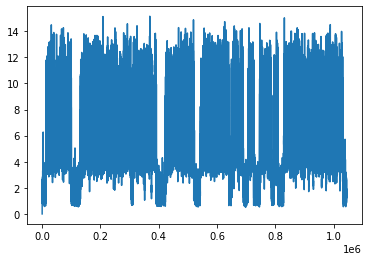

In [9]:
plt.plot(rmsd)

## Discretize trajectory

We'll just do a simple k-means clustering on the RMSDs.

[Deeptime k-means clustering documentation](https://deeptime-ml.github.io/latest/notebooks/clustering.html)

In [51]:
# Initialize the estimator
# Perform the clustering

kmeans_estimator = KMeans(
    n_clusters=n_clusters,
    # init_strategy='uniform',
    max_iter=1000,
    fixed_seed=1337,
    n_jobs=4,
    progress=tqdm.tqdm
)

clustering = kmeans_estimator.fit(rmsd).fetch_model()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [52]:
# Discretize the trajectory
discrete_trajectory = clustering.transform(rmsd)

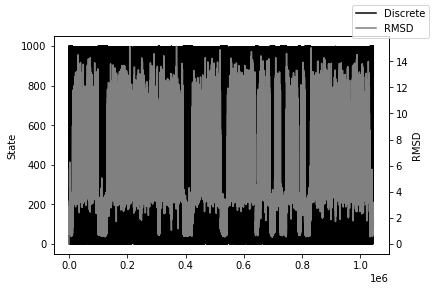

In [53]:
# Plot the RMSDs and discrete trajectory
fig, discrete_ax = plt.subplots(1,1)
rmsd_ax = discrete_ax.twinx()

rmsd_ax.plot(rmsd, color='gray', label='RMSD')
rmsd_ax.set_ylabel('RMSD')

discrete_ax.plot(discrete_trajectory, color='k', label='Discrete')
discrete_ax.set_ylabel('State')

fig.legend()

## Build MSM

In [54]:
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM

In [55]:
lag = 1
count_model = TransitionCountEstimator(lag, 'sliding').fit_fetch(discrete_trajectory)
msm = MaximumLikelihoodMSM().fit_fetch(count_model.submodel_largest())

### Visualize results of MSM

In [56]:
# Sort clusters by RMSD, so we get smooth plots of stationary distributions
cluster_sort_order = np.argsort(clustering.cluster_centers, axis=0)

In [57]:
# Get the histogram in each bin from the full trajectory
hist_bins, hist_counts = np.unique(discrete_trajectory, return_counts=True)
hist_counts = hist_counts/sum(hist_counts)

In [58]:
unfolded_thresh = 7.19
folded_thresh = 1.4

unfolded = np.argwhere(clustering.cluster_centers.flatten() > unfolded_thresh)
folded = np.argwhere(clustering.cluster_centers.flatten() < folded_thresh)
len(unfolded), len(folded)

(381, 49)

In [60]:
msm.stationary_distribution.shape

(999,)

In [64]:
dir(count_model)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_count_matrix',
 '_count_matrix_full',
 '_counting_mode',
 '_lag',
 '_state_histogram',
 '_state_histogram_full',
 '_states_manager',
 'connected_sets',
 'copy',
 'count_matrix',
 'count_matrix_full',
 'count_matrix_histogram',
 'counting_mode',
 'get_params',
 'is_connected',
 'is_full_model',
 'lagtime',
 'n_states',
 'n_states_full',
 'selected_count_fraction',
 'selected_state_fraction',
 'set_params',
 'state_histogram',
 'state_histogram_full',
 'state_symbols',
 'state_symbols_with_blank',
 'states',
 'states_to_symbols',
 'submo

In [72]:
active_states = count_model.connected_sets()[0]
cluster_sort_order = np.argsort(clustering.cluster_centers[active_states], axis=0)

In [73]:
msm.transition_matrix.shape

(999, 999)

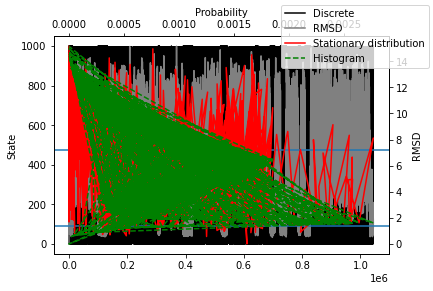

In [74]:
# Plot the RMSDs and discrete trajectory
fig, discrete_ax = plt.subplots(1,1)
rmsd_ax = discrete_ax.twinx()

rmsd_ax.plot(rmsd, color='gray', label='RMSD')
rmsd_ax.set_ylabel('RMSD')
discrete_ax.plot(discrete_trajectory, color='k', label='Discrete')
discrete_ax.set_ylabel('State')
rmsd_ax.set_xlabel('Time (ps)')

stationary_ax = rmsd_ax.twiny()
stationary_ax.plot(
    msm.stationary_distribution[cluster_sort_order],
    clustering.cluster_centers[cluster_sort_order].flatten(),
    color='red',
    label='Stationary distribution'
)
stationary_ax.plot(
    hist_counts[cluster_sort_order],
    clustering.cluster_centers[hist_bins.astype(int)][cluster_sort_order].flatten(),
    color='green',
    linestyle='--',
    label='Histogram'
)
stationary_ax.set_xlabel('Probability')

rmsd_ax.axhline(unfolded_thresh)
rmsd_ax.axhline(folded_thresh)

fig.legend()

In [ ]:
# Look at the density of states
plt.hist(clustering.cluster_centers)

### Plot potential

In [ ]:
potential = -np.log(msm.stationary_distribution)

plt.plot(
    clustering.cluster_centers[cluster_sort_order.flatten()],
    potential[cluster_sort_order])

plt.axvline(folded_thresh)
plt.axvline(unfolded_thresh)

plt.xlabel('RMSD')
plt.ylabel('-$\\ln( P^{equil} )$')

### Save the model

In [ ]:
mfpt_folding = msm.mfpt(unfolded.flatten(), folded.flatten())

In [ ]:
mfpt_unfolding = msm.mfpt(folded.flatten(), unfolded.flatten())

In [49]:
mfpt_folding, mfpt_unfolding

print(f"Folding time: {mfpt_folding * universe.trajectory.dt * stride / 1000:.2f}ns")
print(f"Unfolding time: {mfpt_unfolding * universe.trajectory.dt * stride / 1000:.2f}ns")
# ~500 steps @ 200ps/step = 0.1µs
# These MFPTs seem super high?

Folding time: 236.47ns
Unfolding time: 57.10ns


In [44]:
208/20 # Ballpark µs/transition

10.4

In [42]:
np.savez('transition_matrix', transition_matrix=msm.transition_matrix,
         states_unfolded = unfolded,
         states_folded = folded,
         cluster_centers = clustering.cluster_centers,
         mfpt_folding = mfpt_folding,
         mfpt_unfolding = mfpt_unfolding,
         )